In [3]:
# Active subglacial lake classifcation using neural networks
#
# Author: Anastasia Horne
# Date: 2024-12-01

# Set up computing environment

In [4]:
# Import libraries
import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import random
import rasterio
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_regression
import xarray as xr
import rioxarray
import seaborn as sns

#for K-Fold Cross Validation
from sklearn.model_selection import KFold

#Import PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

# Changing font sizes globally for all matplotlib plots
plt.rcParams.update({'font.size': 14}) # You can adjust the size as needed

# Functions (Written by Wilson Sauthoff)

In [5]:
def generate_random_coordinates(data_array, list_length):
    """
    Generate a list of random (x, y) coordinates from an xarray DataArray,
    based on actual coordinate values rather than indices, where the DataArray has non-NaN values.

    Parameters:
    data_array (xarray.DataArray): The data array to consider.
    list_length (int): The number of random coordinates to generate.

    Returns:
    list: A list of (x, y) coordinate tuples.
    """
    # Ensure the DataArray has coordinate labels
    if not all(dim in data_array.coords for dim in ['x', 'y']):
        raise ValueError("DataArray must have 'x' and 'y' coordinates.")

    # Flatten the array and get the non-NaN values along with their coordinates
    non_nan_array = data_array.stack(all_points=['x', 'y']).dropna('all_points')

    # Randomly select 'list_length' indices
    selected_indices = np.random.choice(non_nan_array.all_points.size, size=list_length, replace=False)

    # Extract the x and y coordinates of these points
    coordinates = [tuple(non_nan_array.all_points.values[i]) for i in selected_indices]

    return coordinates

# Example usage:
# Assuming 'data' is an xarray DataArray loaded with 'x' and 'y' coordinates.
# coords = generate_random_coordinates_from_values(data, 10)
# print(coords)

In [6]:
def sample_dataset_at_points(geodataframe, sampled_data_array, sampled_dataset_str):
    '''
    Take geodataframe with geometry column of polygons; use centroid of each polygon
    as a sampling point; sample on dataset and add sampled value as a new column to 
    geodataframe
    
    geodataframe: contains geometry column with polygons that will be the sampling 
    points at the centroids of each polygon (as geopandas geodataframe)
    sampled_data_array: raster dataset to be sampled at discrete points (as xarray 
    dataarray)
    sampled_dataset_str: string of dataset name to use as new column name in the 
    geodataframe (as string)
    '''
    # Initialize a list to store the sampled data
    sampled_data = []

    # Iterate over each row in the GeoDataFrame
    for index, row in geodataframe.iterrows():
        # Get the coordinates of the point
        x, y = row.geometry.centroid.x, row.geometry.centroid.y

        # Sample the data from the DataArray
        # Assuming the DataArray has dimensions ('x', 'y')
        sampled_value = sampled_data_array.sel(x=x, y=y, method='nearest').values
        sampled_data.append(sampled_value)

    # Add the sampled data as a new column to the GeoDataFrame
    geodataframe[sampled_dataset_str] = sampled_data
    
    return geodataframe

# Example usage
# SiegfriedFricker2018_features = sample_dataset_at_points(SiegfriedFricker2018_outlines, bedmachine.bed, bed_elev_bedmachine)

In [7]:
def create_geodataframe(coords_list, prefix):
    # Create a list of Point objects from the coordinates
    points = [Point(xy) for xy in coords_list]

    # Create a list of names for the points
    names = [f'{prefix}_point_{i+1:02d}' for i in range(len(points))]

    # Create a DataFrame with these points and names
    df = pd.DataFrame({'name': names, 'geometry': points})

    # Convert DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry')

    return gdf

# # Example usage with a custom prefix
# coords_list = [[1, 2], [3, 4], [5, 6]]  # Example list of coordinates
# gdf_with_name_column = create_geodataframe_with_name_column(coords_list, prefix='custom')

In [8]:
def geodataframe_to_coords_list(gdf):
    coords_list = [[point.x, point.y] for point in gdf.geometry]
    return coords_list

# # Assuming 'your_geodataframe' is your existing GeoDataFrame
# coords_list = geodataframe_to_coords_list(your_geodataframe)

In [9]:
def add_sequential_name_column(geodf, prefix):
    '''
    Function to add a column with a specified prefix and sequential numbering
    '''
    n = len(geodf)
    geodf['name'] = [f"{prefix}{i+1}" for i in range(n)]
    return geodf

# # Example usage
# prefix = "Area_"  # Replace with your desired prefix
# gdf = add_sequential_name_column(gdf, prefix)
# gdf

In [10]:
def random_sample_geodataframe(gdf, sample_size):
    """
    Take a random sample of rows from a GeoDataFrame.

    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame from which to sample.
    sample_size (int): The number of samples to take.

    Returns:
    GeoDataFrame: A new GeoDataFrame containing the random sample.
    """
    if sample_size > len(gdf):
        raise ValueError("Sample size cannot be larger than the number of rows in the GeoDataFrame.")

    # Randomly sample the indices
    sample_indices = random.sample(range(len(gdf)), sample_size)

    # Return the sampled rows
    return gdf.iloc[sample_indices]

# Import Datasets

In [11]:
#this directory is simply to make the code easier to run for the grader. (There are two ones you will need to do manually, marked with *)
Directory= "../../"

In [20]:
# Log into NASA Earthdata to search for datasets
# Note: you need a NASA Earthdata to login (https://urs.earthdata.nasa.gov/users/new)
#Not cloud hosting bedmachine (due to issue with interrupted streaming)
#cloud hosting ice velocity
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/jovyan


Enter your Earthdata Login username:  anaHorne
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 02/01/2025
Using user provided credentials for EDL


### Import bedMachine from folder

In [13]:
# Open dataset
bedmachine = xr.open_dataset('BedMachineAntarctica-v3.nc')
bedmachine

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    dataid     (y, x) int8 ...
    geoid      (y, x) int16 ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

#### Find Hydropotential 

In [14]:
# Assign new data variable of hydropotential to ATL15_dh xarray.Dataset
# Follows Shreve 1972, where h_i=Zsurf-Zbed
# Adds g (gravitational acceleration) to make units Pa and unit conversion to kPa
# Use BedMachine bed topography for Zbed; static BedMachine surface topography for static Zsurf
bedmachine = bedmachine.assign(static_hydropotential_kPa = (9.8 * ((917*bedmachine['surface']) + (997-917)*bedmachine['bed']))/1e3)
bedmachine

<xarray.Dataset>
Dimensions:                    (x: 13333, y: 13333)
Coordinates:
  * x                          (x) int32 -3333000 -3332500 ... 3332500 3333000
  * y                          (y) int32 3333000 3332500 ... -3332500 -3333000
Data variables:
    mapping                    |S1 ...
    mask                       (y, x) int8 ...
    firn                       (y, x) float32 ...
    surface                    (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    thickness                  (y, x) float32 ...
    bed                        (y, x) float32 -5.916e+03 ... -3.664e+03
    errbed                     (y, x) float32 ...
    source                     (y, x) int8 ...
    dataid                     (y, x) int8 ...
    geoid                      (y, x) int16 ...
    static_hydropotential_kPa  (y, x) float32 -4.638e+03 ... -2.873e+03
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

### Import Ice Velocity

In [21]:
# Find cloud-hosted MEaSUREs Phase-Based Antarctica Ice Velocity Map, Version 1
# DOI from https://nsidc.org/data/NSIDC-0754/versions/1
results = earthaccess.search_data(
    doi='10.5067/PZ3NJ5RXRH10',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 1


In [22]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

 Opening 1 granules, approx size: 6.49 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0754.001/1996.01.01/antarctic_ice_vel_phase_map_v01.nc>]

In [23]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ice_vel = xr.open_dataset(files[0])

In [24]:
# Specify the variables to keep
variables_to_keep = ['x', 'y', 'VX', 'VY']

variables_to_drop = [var for var in ice_vel.variables if var not in variables_to_keep]

# Drop variables to reduce memory consumption
ice_vel = ice_vel.drop_vars(variables_to_drop)
ice_vel

<xarray.Dataset>
Dimensions:  (x: 12445, y: 12445)
Coordinates:
  * x        (x) float64 -2.8e+06 -2.8e+06 -2.799e+06 ... 2.799e+06 2.8e+06
  * y        (y) float64 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
Data variables:
    VX       (y, x) float32 ...
    VY       (y, x) float32 ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

In [ ]:
# Calculate velocity magnitude
vel_mag = (ice_vel['VX']**2 + ice_vel['VY']**2)**0.5

In [ ]:
del ice_vel #decrease memory consumption

### Import Grounding Line*

In [ ]:
# Scripps Grounding Line (Depoorter and others, 2013)
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file('Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

### Import Siegfried Known Lakes

In [25]:
# Import subglacial lake outlines and view head of geodataframe
exec(open('SiegfriedFricker2018_outlines.py').read())
SiegfriedFricker2018_outlines

name                                           geometry  \
0    Bindschadler_1  POLYGON ((-792264.327 -691480.857, -791281.458...   
1    Bindschadler_2  POLYGON ((-842788.063 -708464.240, -842354.948...   
2    Bindschadler_3  POLYGON ((-874893.221 -654533.044, -876415.673...   
3    Bindschadler_4  POLYGON ((-828821.778 -584874.415, -828822.032...   
4    Bindschadler_5  POLYGON ((-858067.460 -573467.564, -858714.391...   
..              ...                                                ...   
126      Whillans_6  POLYGON ((-451544.869 -488823.261, -451209.964...   
127      Whillans_7  POLYGON ((-543163.376 -500759.165, -542800.367...   
128      Whillans_8  POLYGON ((-654478.748 -281124.560, -653777.327...   
129        Wilkes_1  POLYGON ((2214185.180 -666018.604, 2214317.389...   
130        Wilkes_2  POLYGON ((1985649.483 -1222665.850, 1986964.16...   

       area (m^2)  perimeter (m)  \
0    1.943146e+08   51147.562479   
1    1.072249e+08   37249.152584   
2    1.404559e+08   44183.483257   
3    2.816411e+08   62680.016773   
4    3.923966e+08   73686.203194   
..            ...            ...   
126  7.458477e+07   31952.842516   
127  7.696570e+07   32373.996995   
128  1.625714e+08   45873.974279   
129  5.880773e+08   89565.314574   
130  1.766583e+08   48307.837257   

                                                  cite  
0    Smith and others, 2009, J. Glac., doi:10.3189/...  
1    Smith and others, 2009, J. Glac., doi:10.3189/...  
2    Smith and others, 2009, J. Glac., doi:10.3189/...  
3    Smith and others, 2009, J. Glac., doi:10.3189/...  
4    Smith and others, 2009, J. Glac., doi:10.3189/...  
..                                                 ...  
126  Smith and others, 2009, J. Glac., doi:10.3189/...  
127  Smith and others, 2009, J. Glac., doi:10.3189/...  
128  Smith and others, 2009, J. Glac., doi:10.3189/...  
129  Smith and others, 2009, J. Glac., doi:10.3189/...  
130  Smith and others, 2009, J. Glac., doi:10.3189/...  

[131 rows x 5 columns]

### Import Candidate Outlines

In [26]:
# # Import subglacial lake candidate outlines and view head of geodataframe
# # Open parquet file of lake candidates generated from regions with >85th percentile of ATL15 delta_h standard deviation
candidate_outlines = gpd.read_parquet('lake_candidates_greaterthan85thpercentile_stddev.parquet')
candidate_outlines
#can't get rid of above code because we need to remove candidates from non-lakes)

geometry    area (m^2)  \
4      POLYGON ((-1178260.129 -1145589.655, -1178832....  4.180041e+07   
9      POLYGON ((-1156639.235 -1135234.310, -1156264....  4.083880e+08   
12     POLYGON ((-1214253.083 -1119724.096, -1215252....  2.869237e+07   
22     POLYGON ((-1366223.331 -934221.689, -1367223.1...  1.312104e+08   
28     POLYGON ((-1403216.089 -876875.224, -1404215.8...  1.376467e+08   
...                                                  ...           ...   
57024  POLYGON ((132483.265 2092314.537, 131483.461 2...  2.227342e+07   
57030  POLYGON ((-204027.041 2087016.504, -204450.773...  2.928545e+07   
57079  POLYGON ((379290.366 2097014.179, 378948.802 2...  2.016561e+07   
57104  POLYGON ((324445.684 2118564.781, 325445.488 2...  3.783714e+08   
57259  POLYGON ((341570.631 2136005.114, 342105.637 2...  2.671123e+07   

           perim (m)  percentile                           centroid  
4       29943.633052       99.95  POINT (-1174558.548 -1149692.960)  
9       88088.788009       99.95  POINT (-1161256.273 -1121625.532)  
12      21134.164918       99.95  POINT (-1214303.214 -1122853.197)  
22      62944.465867       99.95   POINT (-1362989.736 -943502.265)  
28      58161.087310       99.95   POINT (-1398807.790 -885150.799)  
...              ...         ...                                ...  
57024   26822.849897       90.00     POINT (133406.578 2088091.479)  
57030   28758.683651       90.00    POINT (-207048.715 2089986.181)  
57079   23928.831355       90.00     POINT (377444.169 2093993.338)  
57104  169028.083476       90.00     POINT (335180.388 2109318.664)  
57259   47136.308122       90.00     POINT (345446.090 2147903.012)  

[3008 rows x 5 columns]

# Datasets added in by Ana*

In [26]:
#Data from . Li, L., Aitken, A.R.A., Lindsay, M.D. et al. Sedimentary basins reduce stability of Antarctic ice streams through groundwater feedbacks.
#File names we are interested in to start
files=["Rebound_Bed_Topography.ers", "Rebound_Bed_Topography_Variation.ers", "Gravity_Variation_ANTGG_BG_HP30_STD30.ers", "Gravity_ANTGG_BG.ers", "Gravity_ANTGG_FAA.ers", "Curie_Depth.ers", 
       "Crust_Thickness_ANTCRUST.ers", "Heat_Flux.ers", "Gravity_ANTGG_Iso_Airy.ers", "Mean_Curvature.ers", "Basal_Friction.ers"]

#shortened names for our files
names=["Rebound_Bed_Topography", "Rebound_Bed_Topography_Variation"]

# Path to your .ers file
Dir = 'ERS Data/' 

#where we will store each individual dataset from our files array
setsInterest=[]

for file in files:
    ers_file_path= Dir+file
    # Open the .ers file using rasterio
    with rasterio.open(ers_file_path) as src:
        # Read the data
        data = src.read()
        # Capture the affine transform and CRS
        transform = src.transform
        crs = src.crs

    # Create an xarray DataArray from the raster data
    data_array = xr.DataArray(
        data,
        dims=('band', 'y', 'x'),  # Assuming a typical raster structure
        coords={
            'band': range(1, data.shape[0] + 1),
            'y': range(data.shape[1]),
            'x': range(data.shape[2]),
        },
        attrs={'transform': transform, 'crs': crs}
    )

    # Optionally convert the DataArray to a Dataset if needed
    dataset = data_array.to_dataset(name='variable_name')
    
    #add dataset to our data set array
    setsInterest.append(dataset)

# Now you have the dataset
#convert x,y to appropriate coord system
#array of our 4 values for each file (x_min, x_max, y_min, y_max), obtained fron R code output transfered to a txt file
coordLim=[(-3335000, 3335000, -3335000, 3335000), (-3335000, 3335000, -3335000, 3335000), (-3345000, 3345000, -3345000, 3345000),
         (-3345000, 3345000, -3345000, 3345000), (-3345000, 3345000, -3345000, 3345000), (-2705000, 2815000, -2315000, 2215000),
         (-6285000, 7375000, -3445000, 4265000), (-2705000, 2815000, -2315000, 2215000), (-3345000, 3345000, -3345000, 3345000),
         (-3345000, 3345000, -3345000, 3345000), (-2705000, 2815000, -2315000, 2215000)]

#need to limit each plot to its max, min variable values (min,max), obtained fron R code output transfered to a txt file
varBounds=[(-5000, 4257.48), (1.651938, 1537.704), (0.01472981, 46.48711), (-405.9995, 381.6063), (-270.9004, 155.8836), (7.288774, 64.1349),
          (7.515578, 64.9567), (42.69382, 239.3418), (-302.3267, 275.983), (-0.08815426, 0.08105425), (0, 150)]

#check to make sure above values match the amount of files
print("We have the same amount of files as coordinate extent tuples: ", len(coordLim)==len(files))

i=0
for dataset, extent in zip(setsInterest, coordLim):
    
    #set min, max vals of
    x_min= extent[0]
    x_max= extent[1]
    y_min= extent[2]
    y_max= extent[3]

    #x_min, x_max, y_min, y_max =-3335000, 3335000, -3335000, 3335000

    # Create mapping conversion factor to map array location to polar stereographic x, y
    x_conv = (x_max-x_min)/(dataset.dims['x']-1)
    y_conv = (y_max-y_min)/(dataset.dims['y']-1)

    # Convert each x and y from pixel (pc) coords to polar stereo (ps) coords
    x_ps = x_min+dataset['x']*x_conv
    y_ps = y_min+dataset['y']*y_conv

    #change the coords in the file and flip our image to have the correct orientation
    dataset['x']=x_ps
    dataset['y']=np.flip(y_ps)
    
    #put our dataset with new coordinates back into our entire array
    setsInterest[i]=dataset
    i+=1

#check for na values
nullIdx=[]
i=0
for dataset in setsInterest:
    global_mean=dataset.mean()
    setsInterest[i]=dataset.fillna(global_mean)
    i+=1  

j=0
for dataset, bounds in zip(setsInterest, varBounds):
    #clip data array to grounding line
    dataset.rio.write_crs("epsg:3031", inplace=True)
    clipped= dataset.rio.clip(Scripps_landice.geometry, Scripps_landice.crs)

    #convert all NaN values to the global mean
    mean=clipped["variable_name"][0].mean()
    clippedNaN= clipped.fillna(mean)
    
    #put our dataset with clipped coordinates and changed NaN values back into our entire array
    setsInterest[j]=clippedNaN
    j+=1

#convert each to geopandas dataframe 
sedBas=[]
for dataset in setsInterest:
    #get the data values
    df=dataset["variable_name"][0][0]
    #convert dtaset of values to a pd dataframe
    df2=df.to_dataframe()
    #make x a column, not the index
    df2.reset_index(level=['x'], inplace=True)
    #drop unused columns
    df2=df2.drop(columns=['band', 'spatial_ref'])

    #get coords in Point(xy) form, to match to lakes/nonlakes
    geometry=[Point(xy) for xy in zip(df2['x'], df2['y'])]

    #convert to gpd, so we can do point selection and add to a vector of all 'files' from this paper
    gpd1= gpd.GeoDataFrame(df2, geometry=geometry)
    gpd2=gpd1.drop(columns=['x','y'])
    sedBas.append(gpd2)



We have the same amount of files as coordinate extent tuples:  True


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


# Pre-process Data (1) - Clip Values and Sample Points

In [27]:
# Clip a data array to grounding line and both the previously identified lakes and lake candidates
bedmachine.rio.write_crs("epsg:3031", inplace=True)
nonlake = bedmachine.surface.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)

In [28]:
nonlake = nonlake.rio.clip(SiegfriedFricker2018_outlines.geometry.values, SiegfriedFricker2018_outlines.crs, invert=True)

In [ ]:
# nonlake.plot()
# plt.title("Identified Lakes")
# plt.savefig("lakes.jpg")

In [29]:
nonlake = nonlake.rio.clip(candidate_outlines.geometry.values, candidate_outlines.crs, invert=True)

In [30]:
#find confirmed nonlakes (areas that aren't known lakes or lake candidates)
nonlake_sample_coords = generate_random_coordinates(nonlake, 2*len(SiegfriedFricker2018_outlines))
print(len(nonlake_sample_coords))

262


In [ ]:
# Plotting nonlake sample points
# plt.figure(figsize=(7, 6))
# nonlake.plot()
# x, y = zip(*nonlake_sample_coords)
# plt.scatter(x, y, s=1, color='red', marker='o')
# plt.title("Non-lakes (red dots)")
# plt.savefig("nonlakes.jpg")

In [31]:
# Make nonlake_coords into a geodataframe
nonlake_gdf = create_geodataframe(nonlake_sample_coords, 'sampling')
# nonlake_gdf

In [32]:
# Make a copy of the SiegfriedFricker2018_outlines geodataframe
SiegfriedFricker2018_geom = SiegfriedFricker2018_outlines

# Drop columns that we will not use
SiegfriedFricker2018_geom = SiegfriedFricker2018_geom.drop(columns=['area (m^2)', 'perimeter (m)', 'cite'])
# SiegfriedFricker2018_geom

In [33]:
# Combine sampling point geodataframes into one and retain info on what type of point they are
SiegfriedFricker2018_geom['type'] = 'lake'
nonlake_gdf['type'] = 'nonlake'

# Now, combine the two GeoDataFrames into one using pandas concat
sampling_points = gpd.GeoDataFrame(pd.concat([SiegfriedFricker2018_geom, nonlake_gdf], ignore_index=True))
sampling_points

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Antarctic Polar Stereographic (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


name                                           geometry  \
0        Bindschadler_1  POLYGON ((-792264.327 -691480.857, -791281.458...   
1        Bindschadler_2  POLYGON ((-842788.063 -708464.240, -842354.948...   
2        Bindschadler_3  POLYGON ((-874893.221 -654533.044, -876415.673...   
3        Bindschadler_4  POLYGON ((-828821.778 -584874.415, -828822.032...   
4        Bindschadler_5  POLYGON ((-858067.460 -573467.564, -858714.391...   
..                  ...                                                ...   
388  sampling_point_258                      POINT (168000.000 362000.000)   
389  sampling_point_259                     POINT (-437500.000 668500.000)   
390  sampling_point_260                     POINT (726500.000 1889000.000)   
391  sampling_point_261                   POINT (-1425500.000 -213000.000)   
392  sampling_point_262                    POINT (1755000.000 1443500.000)   

        type  
0       lake  
1       lake  
2       lake  
3       lake  
4       lake  
..       ...  
388  nonlake  
389  nonlake  
390  nonlake  
391  nonlake  
392  nonlake  

[393 rows x 3 columns]

## Sample data points for features

In [34]:
# Sample the 10 files from ERS for ML model features at lake centroid points
for dataset, name in zip(setsInterest, files):
    if (name[:-4]!="Rebound_Bed_Topography_Variation"):
        sampling_points=sample_dataset_at_points(sampling_points, dataset.to_array(name='variable_name') , name[:-4])

In [35]:
# Sample BedMachine for ML model features at lake centroid points
sampling_points = sample_dataset_at_points(sampling_points, bedmachine.firn, 'firn_bedmachine_m')

In [36]:
sampling_points = sample_dataset_at_points(sampling_points, bedmachine.surface, 'surf_elev_bedmachine_mASL')

In [37]:
sampling_points = sample_dataset_at_points(sampling_points, bedmachine.thickness, 'ice_thickness_bedmachine_m')

In [38]:
sampling_points = sample_dataset_at_points(sampling_points, bedmachine.bed, 'bed_elev_bedmachine_mASL')

In [39]:
sampling_points = sample_dataset_at_points(sampling_points, bedmachine.static_hydropotential_kPa, 'static_hydropotential_kPa')

In [40]:
# Sample ice surface velocity magnitude field for ML model feature at lake centroid points
sampling_points = sample_dataset_at_points(sampling_points, vel_mag, 'surf_velo_ms-1')

In [41]:
sampling_points

name                                           geometry  \
0        Bindschadler_1  POLYGON ((-792264.327 -691480.857, -791281.458...   
1        Bindschadler_2  POLYGON ((-842788.063 -708464.240, -842354.948...   
2        Bindschadler_3  POLYGON ((-874893.221 -654533.044, -876415.673...   
3        Bindschadler_4  POLYGON ((-828821.778 -584874.415, -828822.032...   
4        Bindschadler_5  POLYGON ((-858067.460 -573467.564, -858714.391...   
..                  ...                                                ...   
388  sampling_point_258                      POINT (168000.000 362000.000)   
389  sampling_point_259                     POINT (-437500.000 668500.000)   
390  sampling_point_260                     POINT (726500.000 1889000.000)   
391  sampling_point_261                   POINT (-1425500.000 -213000.000)   
392  sampling_point_262                    POINT (1755000.000 1443500.000)   

        type Rebound_Bed_Topography Gravity_Variation_ANTGG_BG_HP30_STD30  \
0       lake         [[-844.77234]]                         [[1.6973407]]   
1       lake          [[-719.8578]]                         [[3.6409547]]   
2       lake         [[-316.08362]]                         [[1.1891507]]   
3       lake          [[-784.6462]]                        [[0.98690236]]   
4       lake         [[-657.53595]]                         [[1.1987077]]   
..       ...                    ...                                   ...   
388  nonlake          [[799.80963]]                        [[0.76425695]]   
389  nonlake          [[302.83762]]                         [[-999999.0]]   
390  nonlake          [[239.93018]]                         [[2.8470454]]   
391  nonlake          [[-295.6951]]                         [[0.9403443]]   
392  nonlake           [[895.9446]]                         [[2.1566496]]   

    Gravity_ANTGG_BG Gravity_ANTGG_FAA    Curie_Depth  \
0       [[8.608135]]    [[-25.054756]]  [[16.844528]]   
1     [[-10.720383]]    [[-35.629257]]  [[16.397125]]   
2     [[-10.673842]]    [[-21.484741]]  [[13.267043]]   
3     [[-7.4233913]]    [[-36.720154]]  [[13.110097]]   
4     [[-2.6360817]]    [[-28.604969]]  [[13.083018]]   
..               ...               ...            ...   
388   [[-121.43398]]     [[-8.274913]]  [[42.424114]]   
389    [[-42.20061]]     [[2.7901313]]  [[38.429394]]   
390    [[-89.51115]]    [[-59.975388]]  [[42.879314]]   
391    [[22.874641]]     [[11.936415]]   [[23.56074]]   
392   [[-120.12083]]     [[-8.194163]]  [[44.641533]]   

    Crust_Thickness_ANTCRUST       Heat_Flux Gravity_ANTGG_Iso_Airy  \
0              [[27.003998]]  [[111.479866]]         [[-2.8409414]]   
1              [[26.760572]]  [[114.452095]]         [[-16.906057]]   
2              [[26.271393]]   [[137.45886]]         [[-13.963245]]   
3              [[26.068056]]   [[139.76839]]         [[-14.519011]]   
4              [[25.704468]]   [[140.87228]]          [[-8.172482]]   
..                       ...             ...                    ...   
388                 [[40.0]]   [[54.397556]]         [[-22.928116]]   
389            [[38.904404]]   [[57.858337]]          [[1.3844719]]   
390            [[30.987041]]    [[54.26001]]          [[-60.14733]]   
391            [[24.430809]]    [[84.28487]]          [[13.138261]]   
392            [[41.032764]]    [[52.54053]]         [[-31.111023]]   

         Mean_Curvature Basal_Friction firn_bedmachine_m  \
0      [[-0.009460907]]  [[58.146935]]         13.148021   
1     [[-0.0077168867]]   [[78.88247]]         14.331444   
2     [[-0.0068294667]]  [[52.756622]]         14.689835   
3      [[-0.007902406]]  [[55.544144]]         13.867694   
4     [[-0.0073776953]]   [[53.76341]]        14.5030575   
..                  ...            ...               ...   
388  [[-0.00065578753]]  [[51.074856]]         28.308195   
389    [[-0.005465144]]  [[36.541683]]          18.18407   
390    [[-0.008697762]]   [[64.54553]]         17.039646   
391    [[0.00167033

# Pre-Process Data (2) - Compare Features and Create Training/Testing Sets

### Remove Lake Candidates and Check for NaN Values

In [42]:
# Exclude lake candidates from initial train/test steps
training_points = sampling_points[sampling_points['type'].isin(['lake', 'nonlake'])]
training_points

name                                           geometry  \
0        Bindschadler_1  POLYGON ((-792264.327 -691480.857, -791281.458...   
1        Bindschadler_2  POLYGON ((-842788.063 -708464.240, -842354.948...   
2        Bindschadler_3  POLYGON ((-874893.221 -654533.044, -876415.673...   
3        Bindschadler_4  POLYGON ((-828821.778 -584874.415, -828822.032...   
4        Bindschadler_5  POLYGON ((-858067.460 -573467.564, -858714.391...   
..                  ...                                                ...   
388  sampling_point_258                      POINT (168000.000 362000.000)   
389  sampling_point_259                     POINT (-437500.000 668500.000)   
390  sampling_point_260                     POINT (726500.000 1889000.000)   
391  sampling_point_261                   POINT (-1425500.000 -213000.000)   
392  sampling_point_262                    POINT (1755000.000 1443500.000)   

        type Rebound_Bed_Topography Gravity_Variation_ANTGG_BG_HP30_STD30  \
0       lake         [[-844.77234]]                         [[1.6973407]]   
1       lake          [[-719.8578]]                         [[3.6409547]]   
2       lake         [[-316.08362]]                         [[1.1891507]]   
3       lake          [[-784.6462]]                        [[0.98690236]]   
4       lake         [[-657.53595]]                         [[1.1987077]]   
..       ...                    ...                                   ...   
388  nonlake          [[799.80963]]                        [[0.76425695]]   
389  nonlake          [[302.83762]]                         [[-999999.0]]   
390  nonlake          [[239.93018]]                         [[2.8470454]]   
391  nonlake          [[-295.6951]]                         [[0.9403443]]   
392  nonlake           [[895.9446]]                         [[2.1566496]]   

    Gravity_ANTGG_BG Gravity_ANTGG_FAA    Curie_Depth  \
0       [[8.608135]]    [[-25.054756]]  [[16.844528]]   
1     [[-10.720383]]    [[-35.629257]]  [[16.397125]]   
2     [[-10.673842]]    [[-21.484741]]  [[13.267043]]   
3     [[-7.4233913]]    [[-36.720154]]  [[13.110097]]   
4     [[-2.6360817]]    [[-28.604969]]  [[13.083018]]   
..               ...               ...            ...   
388   [[-121.43398]]     [[-8.274913]]  [[42.424114]]   
389    [[-42.20061]]     [[2.7901313]]  [[38.429394]]   
390    [[-89.51115]]    [[-59.975388]]  [[42.879314]]   
391    [[22.874641]]     [[11.936415]]   [[23.56074]]   
392   [[-120.12083]]     [[-8.194163]]  [[44.641533]]   

    Crust_Thickness_ANTCRUST       Heat_Flux Gravity_ANTGG_Iso_Airy  \
0              [[27.003998]]  [[111.479866]]         [[-2.8409414]]   
1              [[26.760572]]  [[114.452095]]         [[-16.906057]]   
2              [[26.271393]]   [[137.45886]]         [[-13.963245]]   
3              [[26.068056]]   [[139.76839]]         [[-14.519011]]   
4              [[25.704468]]   [[140.87228]]          [[-8.172482]]   
..                       ...             ...                    ...   
388                 [[40.0]]   [[54.397556]]         [[-22.928116]]   
389            [[38.904404]]   [[57.858337]]          [[1.3844719]]   
390            [[30.987041]]    [[54.26001]]          [[-60.14733]]   
391            [[24.430809]]    [[84.28487]]          [[13.138261]]   
392            [[41.032764]]    [[52.54053]]         [[-31.111023]]   

         Mean_Curvature Basal_Friction firn_bedmachine_m  \
0      [[-0.009460907]]  [[58.146935]]         13.148021   
1     [[-0.0077168867]]   [[78.88247]]         14.331444   
2     [[-0.0068294667]]  [[52.756622]]         14.689835   
3      [[-0.007902406]]  [[55.544144]]         13.867694   
4     [[-0.0073776953]]   [[53.76341]]        14.5030575   
..                  ...            ...               ...   
388  [[-0.00065578753]]  [[51.074856]]         28.308195   
389    [[-0.005465144]]  [[36.541683]]          18.18407   
390    [[-0.008697762]]   [[64.54553]]         17.039646   
391    [[0.00167033

In [43]:
# Check for NaN values in the DataFrame
nan_values = training_points.isna().any()

# Print columns with NaN values
print("Columns with NaN values:")
print(nan_values[nan_values])

Columns with NaN values:
Series([], dtype: bool)


### Pair Plot

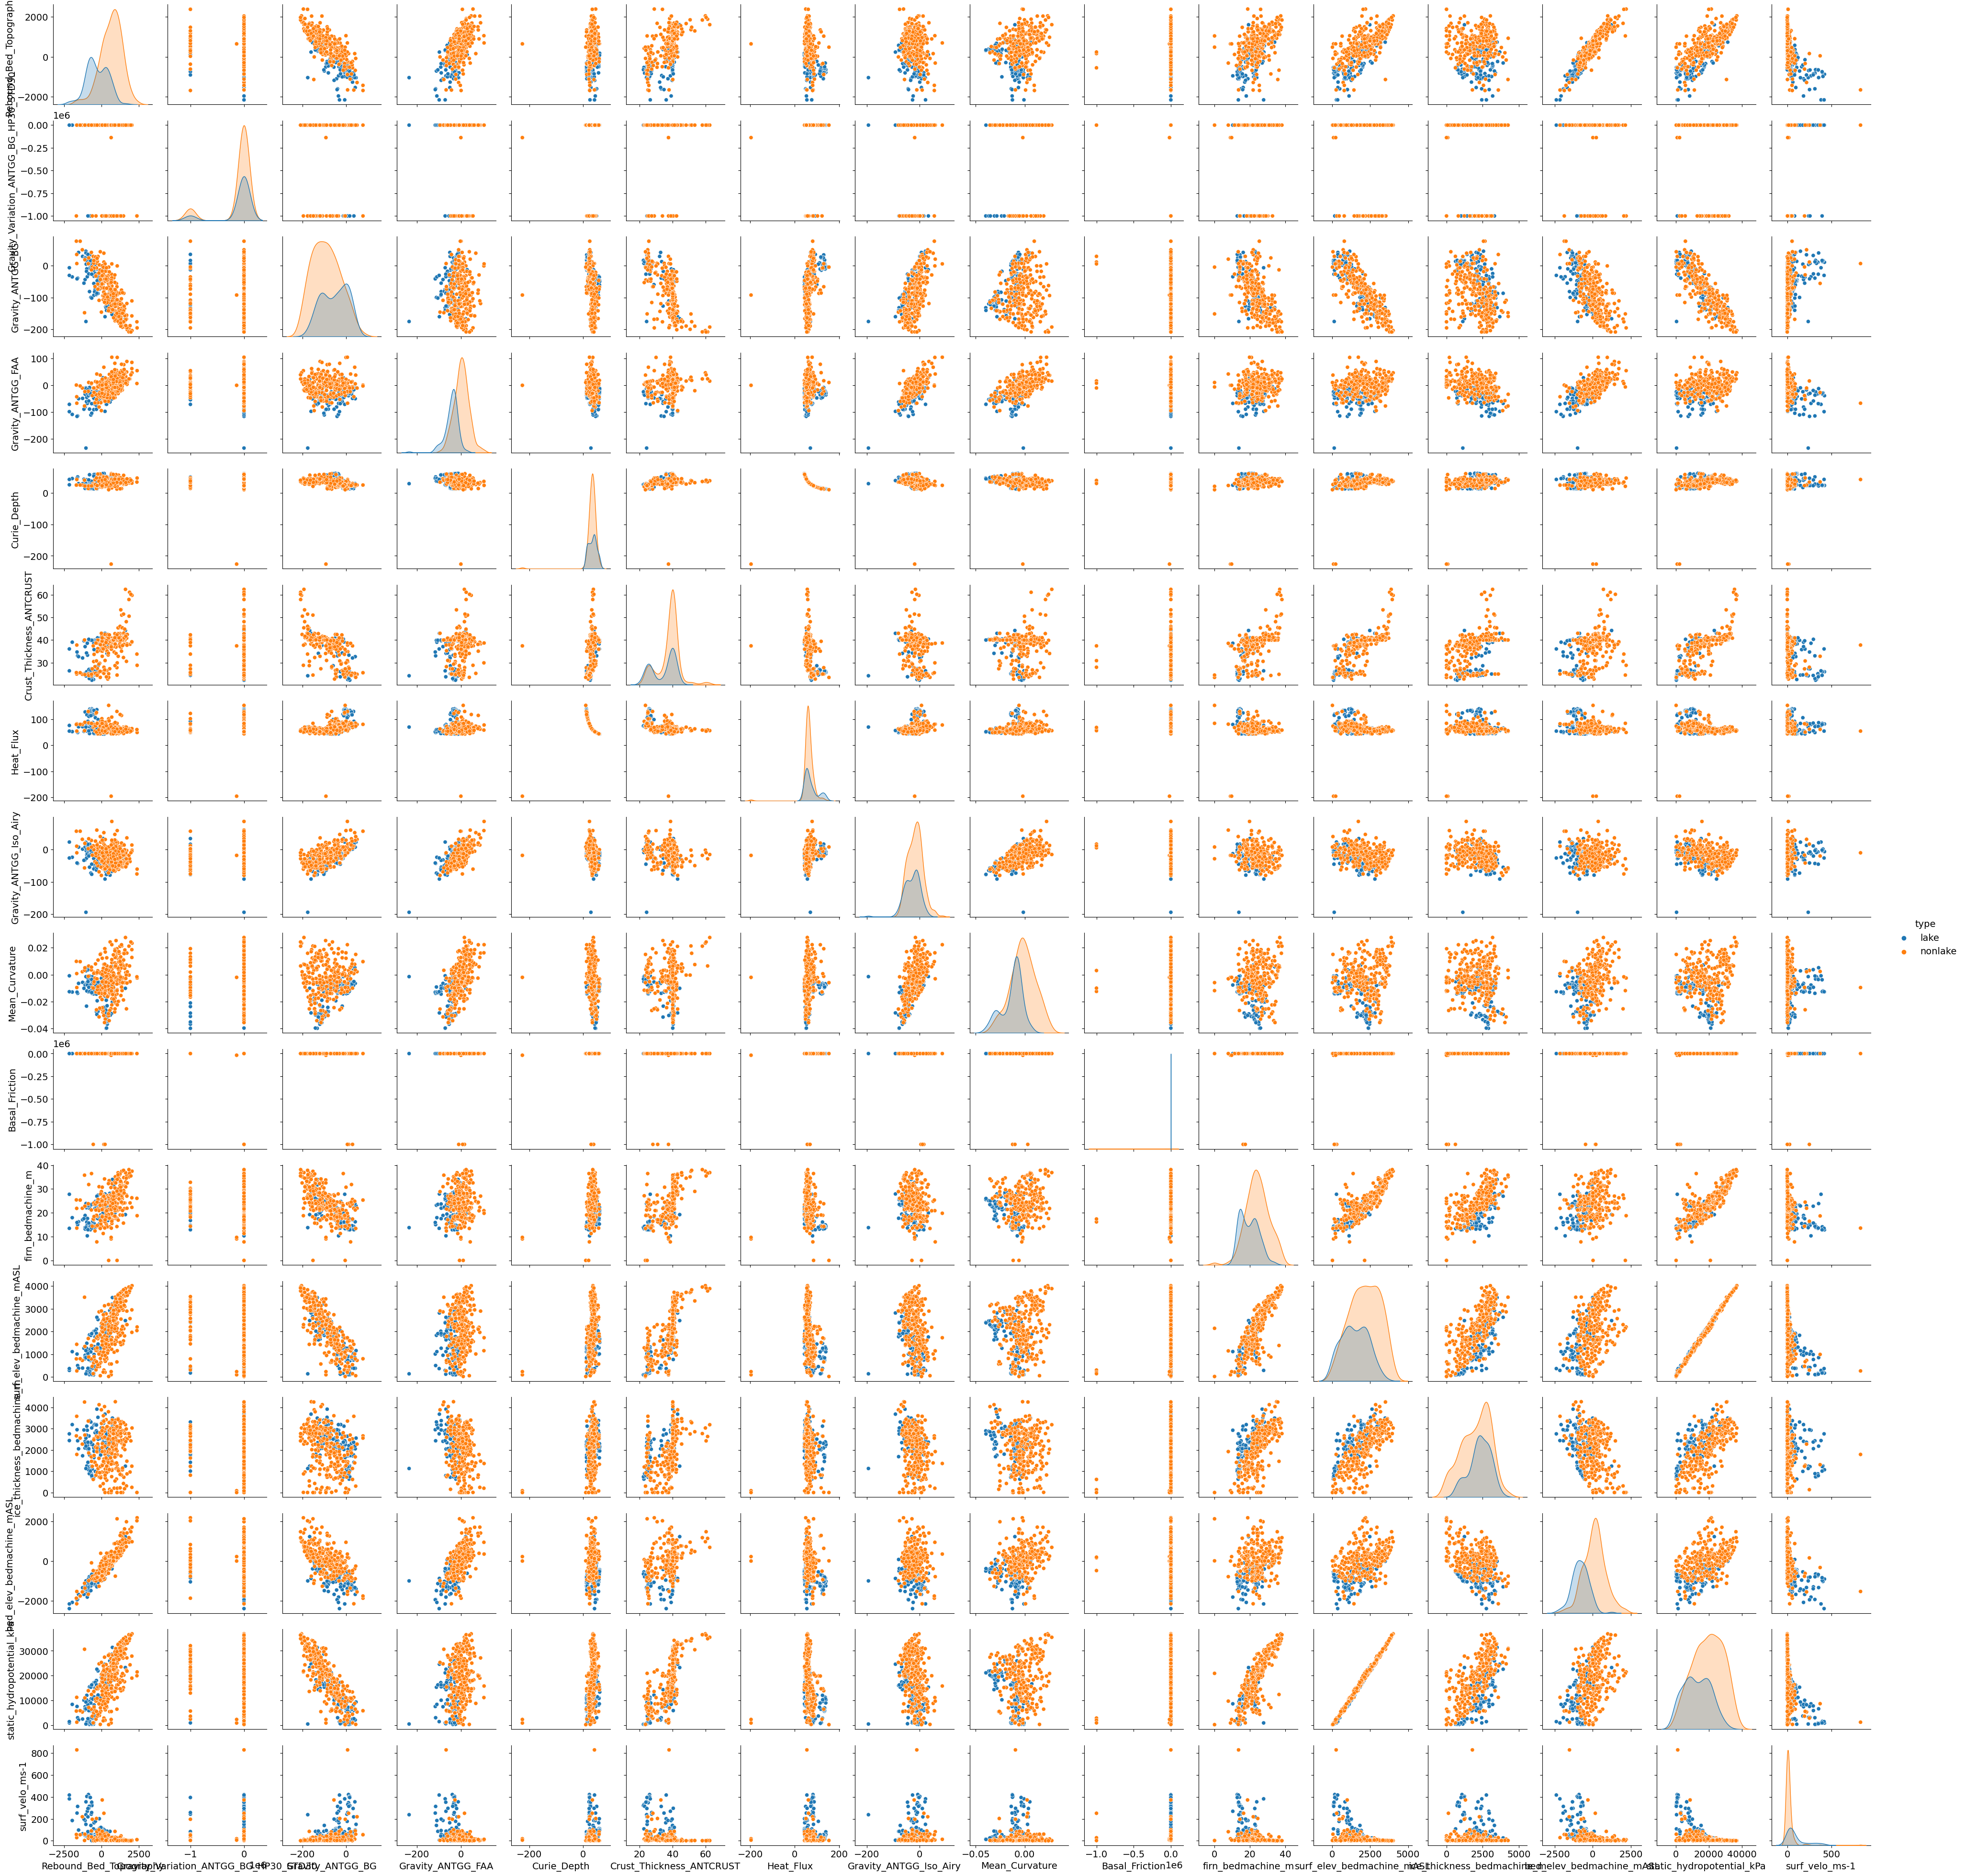

In [44]:
#pair plots
pairData=training_points.drop(columns=['geometry','name'])
pairData = pairData.reset_index(drop=True)

for col in pairData.columns:
    # Use a list comprehension to extract the first value from each entry
    if col != 'type':
        count=0
        for idx in range(pairData.shape[0]):
            try:
                # Attempt to access the value
                pairData[col][idx] = float(pairData[col][idx][0][0])
                count += 1
            except IndexError:
                # If an IndexError occurs, continue to the next iteration
                pairData[col][idx]=float(pairData[col][idx])

#pairplt
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning) #code ran but had "deprecated parameter" warning
    
    # Create the pair plot
    sns.pairplot(pairData, hue='type')
    # plt.savefig("PairPlot1.png")
    plt.show()


### Split Dataset

In [45]:
# Load the training dataset
X = training_points.drop(['name', 'geometry', 'type'], axis=1)
y = training_points['type']

X=pairData.drop(['type'],axis=1)
y=pairData['type']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
#Feature Data
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(X_train)

X_train_np = scaler.transform(X_train)
X_test_np = scaler.transform(X_test)

#if there are extreme values (possible in these sets) the scaler will make them NaN so we have to overwrite them to the mean
meanTrain = np.nanmean(X_train_np)
meanTest = np.nanmean(X_test_np)

# Replace NaN values with the global mean
X_train_np[np.isnan(X_train_np)] = meanTrain
X_test_np[np.isnan(X_test_np)] = meanTest

#print the features list
print(X.columns)
print("We are using", len(X.columns), "features to train the model.")

#convert train and test sets to tensors
X_train_tens = torch.from_numpy(X_train_np)
X_test_tens = torch.from_numpy(X_test_np)

Index(['Rebound_Bed_Topography', 'Gravity_Variation_ANTGG_BG_HP30_STD30',
       'Gravity_ANTGG_BG', 'Gravity_ANTGG_FAA', 'Curie_Depth',
       'Crust_Thickness_ANTCRUST', 'Heat_Flux', 'Gravity_ANTGG_Iso_Airy',
       'Mean_Curvature', 'Basal_Friction', 'firn_bedmachine_m',
       'surf_elev_bedmachine_mASL', 'ice_thickness_bedmachine_m',
       'bed_elev_bedmachine_mASL', 'static_hydropotential_kPa',
       'surf_velo_ms-1'],
      dtype='object')
We are using 16 features to train the model.


In [47]:
#Target Data
#convert target to dummy variables
y_train_np = (y_train.map({'nonlake': 0, 'lake': 1})).to_numpy()
y_test_np = (y_test.map({'nonlake': 0, 'lake': 1})).to_numpy()

#convert from np to tensor
y_train_tens = torch.from_numpy(y_train_np) 
y_test_tens = torch.from_numpy(y_test_np)

In [48]:
#convert datatypes in tensor to torch.float32 so they match the feautres and model weights
y_train_tens = y_train_tens.to(dtype=torch.float32)
y_test_tens = y_test_tens.to(dtype= torch.float32)
X_train_tens = X_train_tens.to(dtype=torch.float32)
X_test_tens = X_test_tens.to(dtype= torch.float32)

#check sizing of all sets to make sure above code did edit the size
print('X_train Tensor:', X_train_tens.shape)
print('y_train Tensor:', y_train_tens.shape)
print('X_test Tensor:', X_test_tens.shape)
print('y_test Tensor:', y_test_tens.shape)

X_train Tensor: torch.Size([275, 16])
y_train Tensor: torch.Size([275])
X_test Tensor: torch.Size([118, 16])
y_test Tensor: torch.Size([118])


# Define PyTorch Neural Network

In [49]:
#Neural Network Definition (layers were chosen by author)
class NeuralNet(nn.Module):
    def __init__(self):
        #layers
        super().__init__()
        self.linear1 = nn.Linear(16, 16)
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, 8)
        self.linear5 = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        #actually apply the layers 
        lay1=self.linear1(x)
        lay2=self.linear2(lay1)
        lay3=self.linear3(lay2)
        lay4=self.linear4(lay3)
        layR=self.relu(lay4)
        lay5=self.linear5(layR)
        #return the result
        return lay5

#accuracy function
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc


# Run the Model Once - Standard 70/30 Split

In [50]:
#Create model instance
device=torch.device("cpu")
model = NeuralNet().to(device)

#Define loss function
criterion = nn.CrossEntropyLoss()

#Define optimization function
optimizer =  torch.optim.SGD(params=model.parameters(), lr=0.001)

#move dataset to deivce (cpu or gpu)
x_train, x_test = X_train_tens.to(device), X_test_tens.to(device)
y_train, y_test = y_train_tens.to(device), y_test_tens.to(device)

In [51]:
#testing/training for loop
epochs=100

#track changes after each iteration
epoch_count, train_loss_values, valid_loss_values, train_acc_values, valid_acc_values = [], [], [], [], []

#train and test loop
for epoch in range(epochs):

    #Put the model in training mode
    model.train()
    optimizer.zero_grad() #reset the gradients

    y = model(x_train).squeeze() #forward pass to get predictions; squeeze output to be same shape as the labels
    y_pred = (torch.sigmoid(y)).squeeze() #convert logits into prediction probabilities
    loss = criterion(y_pred, y_train) #compute the loss
    acc = accuracy(y_train.int(), torch.round(y_pred)) #calculate the accuracy; convert the labels to integers
   
    loss.backward() #backpropagate the prediction loss
    optimizer.step() #gradient descent
    
    #Put the model in evaluation mode
    model.eval() 

    with torch.inference_mode():
        valid = model(x_test).squeeze() #forward pass to get predictions
        valid_pred = torch.sigmoid(valid)   

        valid_loss = criterion(valid_pred, y_test)
        valid_acc = accuracy(y_test.int(), torch.round(valid_pred))    
    
    # Print progress
    if epoch % int(epochs / 100) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')

        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        valid_loss_values.append(valid_loss.detach().numpy())
        train_acc_values.append(acc)
        valid_acc_values.append(valid_acc)



Epoch:    0 | Train Loss: 484.32922, Accuracy: 29.45% | Validation Loss: 215.00583, Accuracy: 38.14%
Epoch:    1 | Train Loss: 484.05978, Accuracy: 31.64% | Validation Loss: 214.91663, Accuracy: 38.98%
Epoch:    2 | Train Loss: 483.79385, Accuracy: 31.64% | Validation Loss: 214.82896, Accuracy: 38.98%
Epoch:    3 | Train Loss: 483.53229, Accuracy: 31.27% | Validation Loss: 214.74228, Accuracy: 38.98%
Epoch:    4 | Train Loss: 483.27338, Accuracy: 31.27% | Validation Loss: 214.65572, Accuracy: 38.98%
Epoch:    5 | Train Loss: 483.01453, Accuracy: 31.27% | Validation Loss: 214.56870, Accuracy: 38.98%
Epoch:    6 | Train Loss: 482.75394, Accuracy: 32.36% | Validation Loss: 214.48886, Accuracy: 41.53%
Epoch:    7 | Train Loss: 482.49799, Accuracy: 34.55% | Validation Loss: 214.40811, Accuracy: 41.53%
Epoch:    8 | Train Loss: 482.23611, Accuracy: 36.00% | Validation Loss: 214.32558, Accuracy: 44.07%
Epoch:    9 | Train Loss: 481.96829, Accuracy: 40.00% | Validation Loss: 214.24342, Accurac

### Overview of "Model Once" Results

In [52]:
print("The distribution of points in the training set:", np.count_nonzero(y_train_np == 1), "Lakes.", np.count_nonzero(y_train_np == 0), "NonLakes.")
print("The distribution of points in the testing set:", np.count_nonzero(y_test_np == 1), "Lakes.", np.count_nonzero(y_test_np == 0), "NonLakes.")

The distribution of points in the training set: 86 Lakes. 189 NonLakes.
The distribution of points in the testing set: 45 Lakes. 73 NonLakes.


Text(0.5, 1.0, 'Nueral Network Accuracy')

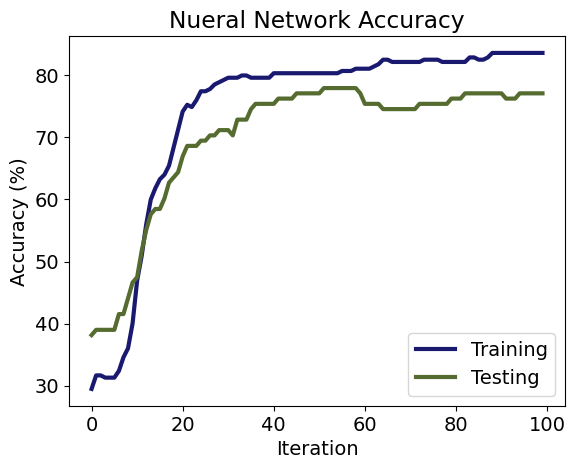

In [53]:
plt.plot(epoch_count, train_acc_values, label="Training", color="midnightblue", linewidth=3)
plt.plot(epoch_count, valid_acc_values, label="Testing", color="darkolivegreen", linewidth=3)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.title("Nueral Network Accuracy")
# plt.savefig("iter_vs_acc5.png")

              precision    recall  f1-score   support

         0.0       0.91      0.70      0.79        73
         1.0       0.65      0.89      0.75        45

    accuracy                           0.77       118
   macro avg       0.78      0.79      0.77       118
weighted avg       0.81      0.77      0.77       118

[[51 22]
 [ 5 40]]


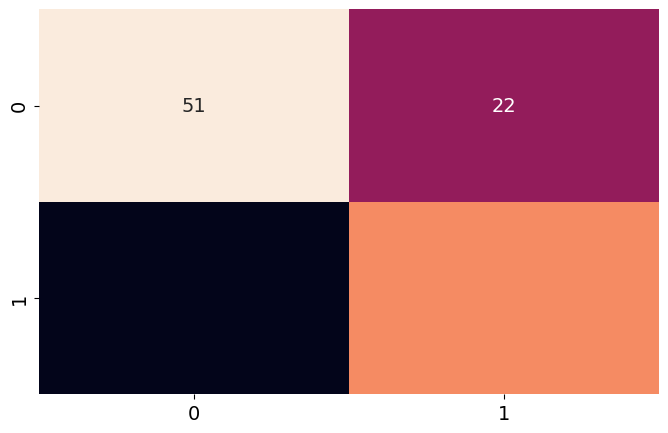

[ 0. -1.  0.  0.  0. -1.  0.  0.  0.  1.  0.  0.  0. -1.  0. -1.  1.  0.
  0.  0.  0.  0. -1.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.
  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0. -1. -1.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  1.
  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0. -1. -1.  0. -1.
  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0. -1. -1.  0.]


In [54]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

y_pred = np.where(valid_pred < 0.5, 0, 1)
y_test2 = [tensor.item() for tensor in y_test]

print(classification_report(y_test2, y_pred))
cf_matrix = confusion_matrix(y_test2, y_pred)
print(cf_matrix)

plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")

plt.show()

print(y_test2 - y_pred)


# K-Fold Cross Validation Approach

In [55]:
#create one dataset
feature_dataset= np.concatenate((X_train_np, X_test_np), axis=0) #adds rows
class_dataset= np.concatenate((y_train_np, y_test_np), axis=0) #adds rows
class_dataset= class_dataset.reshape(-1,1) #convert to match dim of feature dataset
net_dataset= np.concatenate((feature_dataset, class_dataset), axis=1) #add columns
net_dataset

#convert to tensors
X = torch.from_numpy(feature_dataset).to(torch.float32) 
y = torch.from_numpy(class_dataset).to(torch.float32)

In [56]:
def reset_weights(model):
    """
    Reset model weights
    """
    for layer in model.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    return model
    
def train_model(model, X, y, criterion, optimizer, device):
    """
    Train the Model
    model - instance of our neural network
    X - feature training data
    y - target training data
    criterion, optimizer - loss and optimization function to train the model
    device - CPU or GPU
    """
    model.train()
    optimizer.zero_grad() #reset the gradients

    y_out = model(X).squeeze() # forward pass to get predictions
    y_pred = (torch.sigmoid(y_out)).squeeze() #convert logits into prediction probabilities
    loss = criterion(y_pred, y.squeeze()) # compute the loss   
   
    loss.backward() # backward pass
    optimizer.step() # gradient descent 
    
    accuracy = calculate_accuracy(torch.round(y_pred), y.squeeze()) #calc accuracy of this epoch
    
    return loss.item(), accuracy

def validate_model(model, X, y, criterion, device, epoch):
    """
    Validate the Model
    model - instance of our neural network
    X - feature testing data
    y - target testing data
    criterion - loss function to test the model
    device - CPU or GPU
    epoch - number of iteration
    """
    model.eval() #put model in evaluation mode
    with torch.no_grad():
        y_out = model(X).squeeze()
        y_pred =torch.sigmoid(y_out)
        
        loss = criterion(y_pred, y.squeeze()) #loss
        accuracy = calculate_accuracy(torch.round(y_pred), y.squeeze()) #accuracy
        cf_matrix = confusion_matrix(y.squeeze(), torch.round(y_pred)) #confusion matrix
    return loss.item(), accuracy, cf_matrix

def calculate_accuracy(outputs, labels):
    correct = torch.eq(labels, outputs).sum().item()
    acc = correct / len(outputs) * 100
    return acc


def k_fold_cross_validation(model_class, X, y, k_folds, num_epochs, learning_rate, device, **model_kwargs):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    #define results dictionary
    results = {'train_losses': [], 'val_losses': [], 'train_accuracies': [], 'val_accuracies': [], 'fold_final_train_acc': [], 
               'fold_final_val_acc': [], 'fold_train_ratio':[], 'fold_val_ratio': [], 'val_confs':[]}
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f'\nFOLD {fold+1}/{k_folds}')
        
        #Split data for this fold
        X_train, X_val = X[train_idx].to(device), X[val_idx].to(device)
        y_train, y_val = y[train_idx].to(device), y[val_idx].to(device)
        zeros_train = (y_train == 0).sum().item() #nonlake
        ones_train = (y_train == 1).sum().item() #lake
        zeros_val = (y_val == 0).sum().item() #nonlake
        ones_val = (y_val == 1).sum().item() #lake

        #Print fold information
        print(f'Split sizes:')
        print(f'    Training: {len(train_idx)} samples')
        print(f'    Validation: {len(val_idx)} samples')
        print(f"    Distribution of points in the training set: {ones_train} Lakes, {zeros_train} Nonlakes")
        print(f"    Distribution of points in the validation set: {ones_val} Lakes, {zeros_val} Nonlakes")
        
        #Initialize model and optimizer
        model = NeuralNet()
        #reset wieghts
        model=reset_weights(model)
        criterion = nn.CrossEntropyLoss() #create loss function
        optimizer =  torch.optim.SGD(params=model.parameters(), lr=0.01)
        
        #training for loop
        fold_train_losses = []
        fold_val_losses = []
        fold_train_accs = []
        fold_val_accs = []
        conf=[]
        
        for epoch in range(num_epochs):         
            #train
            train_loss, train_acc = train_model(model, X_train, y_train, criterion, optimizer, device)
            #validate
            val_loss, val_acc, conf_matrix = validate_model(model, X_val, y_val, criterion, device, epoch)

            #append results of iteration
            fold_train_losses.append(train_loss)
            fold_val_losses.append(val_loss)
            fold_train_accs.append(train_acc)
            fold_val_accs.append(val_acc)

            #print results of iteration
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

             #append only the last confusion matrix
            if (epoch==49):
                conf.append(conf_matrix)


            
        
        #store results for fold
        results['train_losses'].append(fold_train_losses)
        results['val_losses'].append(fold_val_losses)
        results['train_accuracies'].append(fold_train_accs)
        results['val_accuracies'].append(fold_val_accs)
        results['fold_final_train_acc'].append(train_acc)
        results['fold_final_val_acc'].append(val_acc)
        results['fold_train_ratio'].append(ones_train/zeros_train)
        results['fold_val_ratio'].append(ones_val/zeros_val)
        results['val_confs'].append(conf)
        
        #print final results of fold
        print(f'\nFold {fold+1} Final Results:')
        print(f'Training Accuracy: {train_acc:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f}')
    
    #print overall results
    print('\nOverall Results:')
    print(f'Average Training Accuracy: {np.mean(results["fold_final_train_acc"]):.4f} ± {np.std(results["fold_final_train_acc"]):.4f}')
    print(f'Average Validation Accuracy: {np.mean(results["fold_final_val_acc"]):.4f} ± {np.std(results["fold_final_val_acc"]):.4f}')
    
    return results

#PERFORM CV
results = k_fold_cross_validation(model_class=NeuralNet, X=X, y=y, k_folds=5, num_epochs=50, learning_rate=0.001, device=device, input_size=x_train.shape[1], hidden_size=64)


FOLD 1/5
Split sizes:
    Training: 314 samples
    Validation: 79 samples
    Distribution of points in the training set: 101 Lakes, 213 Nonlakes
    Distribution of points in the validation set: 30 Lakes, 49 Nonlakes
Epoch 1/50:
Training Loss: 580.5237, Training Accuracy: 66.5605
Validation Loss: 130.8860, Validation Accuracy: 63.2911
Epoch 2/50:
Training Loss: 579.8275, Training Accuracy: 69.4268
Validation Loss: 130.6866, Validation Accuracy: 67.0886
Epoch 3/50:
Training Loss: 579.0200, Training Accuracy: 71.3376
Validation Loss: 130.3557, Validation Accuracy: 68.3544
Epoch 4/50:
Training Loss: 577.6654, Training Accuracy: 75.1592
Validation Loss: 129.8211, Validation Accuracy: 78.4810
Epoch 5/50:
Training Loss: 575.4518, Training Accuracy: 79.6178
Validation Loss: 128.9375, Validation Accuracy: 75.9494
Epoch 6/50:
Training Loss: 571.8445, Training Accuracy: 77.7070
Validation Loss: 127.6786, Validation Accuracy: 78.4810
Epoch 7/50:
Training Loss: 566.8373, Training Accuracy: 76.7

### Analysis of Cross Validation Results

In [57]:
def calc_stats(folds):
   #convert list of arrays to 3D numpy array
   arrays = np.array([fold[0] for fold in folds])
    
   #calc mean and std for each result (tp,fp,tn,fn)
   means = np.mean(arrays, axis=0)
   stds = np.std(arrays, axis=0)
   
   return means, stds

means, stds = calc_stats(results['val_confs'])
print("Means:\n", means)
print("Standard deviations:\n", stds)

def calc_metrics(folds):
    arrays = np.array([fold[0] for fold in folds])
    
    # Arrays for each class
    lake_metrics = []
    nonlake_metrics = []
    
    for arr in arrays:
        tn, fp, fn, tp = arr.ravel() #get the individial values for each fold
        
        # Lake metrics
        lake_precision = tp / (tp + fp)
        lake_recall = tp / (tp + fn)
        lake_f1 = 2 * (lake_precision * lake_recall) / (lake_precision + lake_recall)
        
        # Non-lake metrics
        nonlake_precision = tn / (tn + fn)
        nonlake_recall = tn / (tn + fp)
        nonlake_f1 = 2 * (nonlake_precision * nonlake_recall) / (nonlake_precision + nonlake_recall)
        
        lake_metrics.append([lake_precision, lake_recall, lake_f1])
        nonlake_metrics.append([nonlake_precision, nonlake_recall, nonlake_f1])
        
    #return avg and std for each metric
    return {
        'Lake': (np.mean(lake_metrics, axis=0), np.std(lake_metrics, axis=0)),
        'Non-lake': (np.mean(nonlake_metrics, axis=0), np.std(nonlake_metrics, axis=0))
    }

metrics = calc_metrics(results['val_confs'])
print(metrics)

Means:
 [[43.8  8.6]
 [ 4.6 21.6]]
Standard deviations:
 [[4.74973683 2.4979992 ]
 [2.57681975 4.07921561]]
{'Lake': (array([0.72117256, 0.82048539, 0.76064944]), array([0.03552862, 0.11375901, 0.0396443 ])), 'Non-lake': (array([0.90863079, 0.83404642, 0.86768168]), array([0.04064708, 0.05110131, 0.01808049]))}


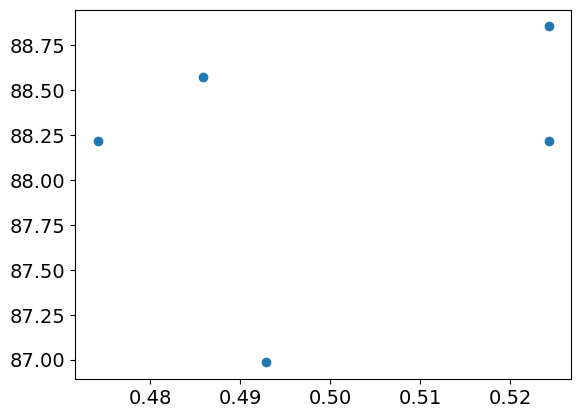

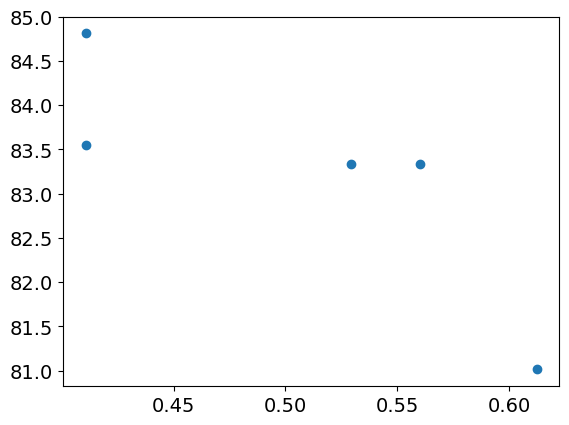

In [58]:
#Lake Distribution and accuracy per fold (tester for more analysis)
plt.scatter(results['fold_train_ratio'],  results['fold_final_train_acc'])
plt.show()
plt.scatter(results['fold_val_ratio'],  results['fold_final_val_acc'])

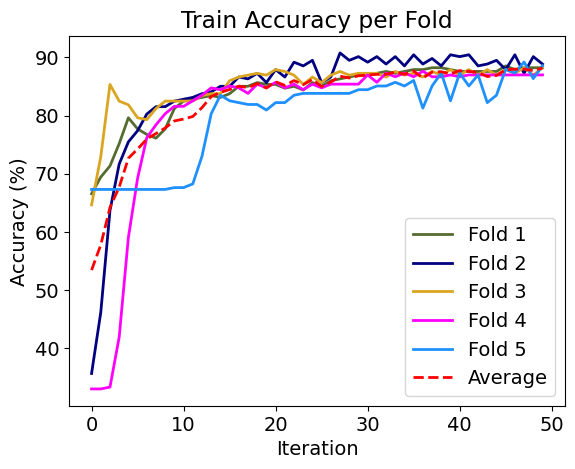

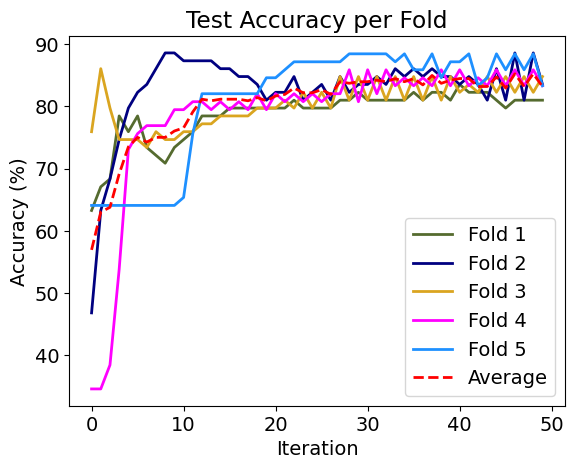

In [59]:
#plot CV Results
colors=["darkolivegreen", "navy", "goldenrod", "magenta", "dodgerblue"]

#plot train acc for each fold
for i in range(0,5):
    plt.plot(results['train_accuracies'][i], label="Fold " + str(i+1), color=colors[i], linewidth=2) 
    
averages_train = []
# For each position in fold
for i in range(50):
    #get all values at this position across folds
    values = [fold[i] for fold in results['train_accuracies']]
    
    # Calculate average
    avg = sum(values) / 5
    averages_train.append(avg)
    
#plot average line, and spruce up the figure    
plt.plot(averages_train, linestyle='--', linewidth=2, color="red", label="Average")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.title("Train Accuracy per Fold")
plt.savefig("train_per_fold3.png")
plt.show()

#plot test acc for each fold
for i in range(0,5):
    plt.plot(results['val_accuracies'][i], label="Fold " + str(i+1), color=colors[i], linewidth=2)
    
averages_val = []
# For each position in fold
for i in range(50):
    # Get all values at this position across folds
    values = [fold[i] for fold in results['val_accuracies']]
    
    # Calculate average
    avg = sum(values) / 5
    averages_val.append(avg)

#plot average line, and spruce up the figure 
plt.plot(averages_val, linestyle='--', linewidth=2, color="red", label="Average")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy per Fold")
plt.savefig("test_per_fold3.png")
plt.show()
